# Localized analysis: band-pass filtering, Hilbert transform

We investigate how band-pass filtering and hilbert transform can be combined in order to extract a tidal signal from the sum of a tidal signal and a low-frequency signal.
See the [main notebook](main.ipynb) for descriptions of the signal and of the filtering and hilbert transforms.

The tidal signal is non-stationary for now, i.e. there is no stationary contribution.

In [1]:
import xarray as xr
import numpy as np

from scipy import signal
import scipy.ndimage as im

import matplotlib.pyplot as plt

from sympy import Symbol, pi, atan, factor, lambdify

import sstats.hfreq as hf
import sstats.tseries as ts
import sstats.sigp as sigp
#import sstats.sigp_AP as sigp_AP
from sstats import get_cmap_colors
#import mitequinox.sigp as sp

rad = 2*np.pi

print_figs = True

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
#
#from dask_jobqueue import PBSCluster
#
#cluster = PBSCluster(processes=5, cores=5,walltime='02:00:00') #processes=7, cores=7
#
#w = cluster.scale(jobs=2)
#
client = Client(cluster)

In [3]:
client

<Client: 'tcp://127.0.0.1:59693' processes=4 threads=4, memory=8.59 GB>

## filter design: firwin vs firwin2

Should probably include alternatives (equivalent to harmonic analysis over a fixed window)

[Link to scipy documentation](https://docs.scipy.org/doc/scipy/reference/tutorial/signal.html#filter-design)

In [4]:
def generate_filter(band, T=10, dt=1/24, lat=None, bandwidth=None, normalized_bandwidth=None):
    """Wrapper around scipy.signal.firwing
    
    Parameters
    ----------
    band: str, float
        Frequency band (e.g. "semidiurnal", ...) or filter central frequency
    T: float
        Filter length in days
    dt: float
        Filter/time series time step
    lat: float
        Latitude (for inertial band)
    bandwidth: float
        Filter bandwidth in cpd
    dt: float
        hours
    """
    numtaps = int(T*24)    
    pass_zero = False
    #
    if band == "subdiurnal":
        pass_zero = True
        cutoff = [1.0 / 2.0]    
    elif band == "semidiurnal":
        omega = 1.9322 #  M2 24/12.4206012 = 1.9322
    elif band == "diurnal":
        omega = 1. # K1 24/23.93447213 = 1.0027
    elif band == "inertial":
        try:
            omega = coriolis(lat) * 3600 / 2.0 / np.pi
        except:
            print("latitude needs to be provided to generate_filter")
    elif isinstance(band, float):
        omega = band
    #
    if bandwidth is not None:
        cutoff = [omega - bandwidth, omega + bandwidth]
    elif normalized_bandwidth is not None:
        cutoff = [omega * (1 - normalized_bandwidth), 
                  omega * (1.0 + normalized_bandwidth),
                 ]
    elif band != "subdiurnal":
        print("bandwidth or normalized_bandwidth needs to be provided")
    #
    h = signal.firwin(
        numtaps, cutoff=cutoff, pass_zero=pass_zero, fs=1/dt, scale=True
    )
    return h

def filter_response(h, dt=1/24):
    """Returns the frequency response"""
    w, hh = signal.freqz(h, worN=8000, fs=1/dt)
    return hh, w

def get_tidal_frequencies(*args, units="cpd"):
    """
    """
    from pytide import WaveTable
    td = WaveTable()
    if units=="cpd":
        scale=86400/2/np.pi
    elif units=="cph":
        scale=3600/2/np.pi
    else:
        # cps
        scale=1/2/np.pi
    return {c: td.wave(c).freq * scale for c in args}



In [5]:
dt = 1/24 # time step in days

tidal_omega = get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2#center frequency
Tw = 30 #filter length
dband = 0.2 # half-bandwidth

print('omega M2:%s'%omega_M2)
print('omega S2:%s'%omega_S2)
print('omega N2:%s'%omega_N2)
print('omega K2:%s'%omega_K2)
#print('omega (M2+S2)/2:%s'%(omega_M2+omega_S2)/2)

omega M2:1.9322736142672448
omega S2:2.0
omega N2:1.8959819677542018
omega K2:2.0054758185413344


In [6]:
dband = [0.1,0.2,0.3] #0.05,
h,h_hat,w = {},{},{}
for d in dband:
    h[str(d)] = generate_filter(omega, T=Tw, dt=dt, bandwidth=d, normalized_bandwidth=None)
    h_hat[str(d)], w[str(d)] = filter_response(h[str(d)], dt)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


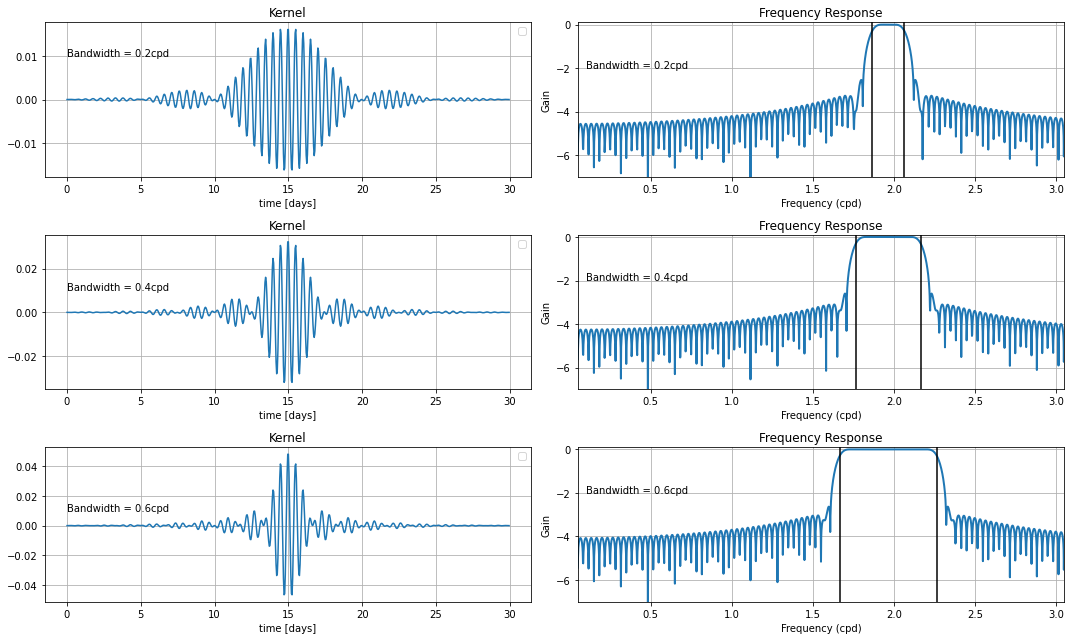

In [7]:
t = np.arange(0,30,dt)
fig, axes = plt.subplots(len(h.keys()),2, figsize=(15,3*len(h.keys())))
for i, k in enumerate(h.keys()):
    ax = axes[i,0]
    ax.plot(t, h[k])
    ax.grid()
    ax.set_xlabel('time [days]')
    ax.set_title('Kernel')
    ax.legend()
    ax.text(0,0.01,'Bandwidth = %scpd'%(2*float(k)))
    ax = axes[i,1]

    ax.plot(w[k], np.log10(abs(h_hat[k])), linewidth=2)
    ax.axvline(omega-float(k), color='k')
    ax.axvline(omega+float(k), color='k')
    ax.set_xlabel('Frequency (cpd)')
    ax.set_ylabel('Gain')
    ax.set_title('Frequency Response')
    #ax.set_ylim(-0.05, 1.05)
    ax.set_ylim(-7, 0.1)
    ax.set_xlim(0.05, 3.05)
    ax.grid(True)
    ax.text(0.1,-2,'Bandwidth = %scpd'%(2*float(k)))
    
fig.tight_layout()

In [9]:
t_size=300
T,T_low = [5,30,80],[5,15,30]
U_high = [0.1]#[0.01,0.05,0.1,1.]
nb_draws = 500

### Generation signal: 

In [10]:
# Incoherent part

U = 0.1 # true variance

# generate time series
u = {}
i = 0
for c in ['M2','S2']:
    for part in ['real','imag']:
        i += 1
        u[c+'_'+part] = ts.exp_autocorr((t_size, dt), T, 
                                 U/np.sqrt(2), 
                                 #burnin=int(10*T/dt),
                                 draws=nb_draws, chunks={'draws':-1,'T':-1},
                                 seed=i,name=c+'_'+part+'_inc'
                                ).persist()


In [11]:
u['M2'] = u['M2_real']+1j*u['M2_imag']
u['S2'] = u['S2_real']+1j*u['S2_imag']

In [12]:
exp_M2 = np.exp(1j*omega_M2*rad*u['M2'].time)
exp_S2 = np.exp(1j*omega_S2*rad*u['M2'].time)

In [13]:
u_M2_inc = u['M2']*exp_M2
u_M2_coh = U*exp_M2
u_M2_mix = u_M2_inc/np.sqrt(2)+u_M2_coh/np.sqrt(2)

u_S2_inc = u['S2']*exp_S2
u_S2_coh = U*exp_S2
u_S2_mix = u_S2_inc/np.sqrt(2)+u_S2_coh/np.sqrt(2)

In [14]:
high_MS_mix = u_M2_mix+u_S2_mix
high_MS_coh = u_M2_coh+u_S2_coh

high_MS_inc = u_M2_inc+u_S2_inc

In [15]:
ds = xr.Dataset({'M2_coh':u_M2_coh,'S2_coh':u_S2_coh,'high_MS_coh':high_MS_coh.rename('u_high'),
                'M2_mix':u_M2_mix,'S2_mix':u_S2_mix,'high_MS_mix':high_MS_mix.rename('u_high'),
                'M2_inc':u_M2_inc,'S2_inc':u_S2_inc,'high_MS_inc':high_MS_inc.rename('u_high')
                })
ds = ds.persist()

In [16]:
for c,om in zip(['M2','S2','high_MS'],[omega_M2,omega_S2,omega]):
    
    for p in ['coh','mix','inc']:
        exp = np.exp(-1j*om*rad*ds[c+'_'+p].time)
        if p=='coh':
#            ds[c+'_'+p+'_complex'] = xr.DataArray(signal.hilbert(ds[c+'_'+p].real,axis=0),dims=["time"])
            ds[c+'_'+p+'_demodulated'] = ds[c+'_'+p]*exp
        else:
#            ds[c+'_'+p+'_complex'] = xr.DataArray(signal.hilbert(ds[c+'_'+p].real,axis=0),dims=["time","draw"])
            ds[c+'_'+p+'_demodulated'] = ds[c+'_'+p]*exp
ds = ds.persist()
ds

<xarray.Dataset>
Dimensions:                  (T: 3, draw: 500, time: 7200)
Coordinates:
  * time                     (time) float64 0.0 0.04167 0.08333 ... 299.9 300.0
  * T                        (T) int64 5 30 80
  * draw                     (draw) int64 0 1 2 3 4 5 ... 495 496 497 498 499
Data variables:
    M2_coh                   (time) complex128 (0.1+0j) ... (-0.08031686801596918-0.05957516858646216j)
    S2_coh                   (time) complex128 (0.1+0j) ... (0.08660254037841576-0.05000000000004867j)
    high_MS_coh              (time) complex128 (0.2+0j) ... (0.006285672362446579-0.10957516858651084j)
    M2_mix                   (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    S2_mix                   (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    high_MS_mix              (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    M2_inc                   (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    S2_inc                   (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    high_MS_inc              (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    M2_coh_demodulated       (time) complex128 (0.1+0j) ... (0.1+0j)
    M2_mix_demodulated       (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    M2_inc_demodulated       (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    S2_coh_demodulated       (time) complex128 (0.1+0j) ... (0.1+6.938893903907228e-18j)
    S2_mix_demodulated       (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    S2_inc_demodulated       (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    high_MS_coh_demodulated  (time) complex128 (0.2+0j) ... (0.10975530623988207+2.4951395116712405e-14j)
    high_MS_mix_demodulated  (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    high_MS_inc_demodulated  (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>

In [17]:
ds_mean = ds.mean('draw').persist()

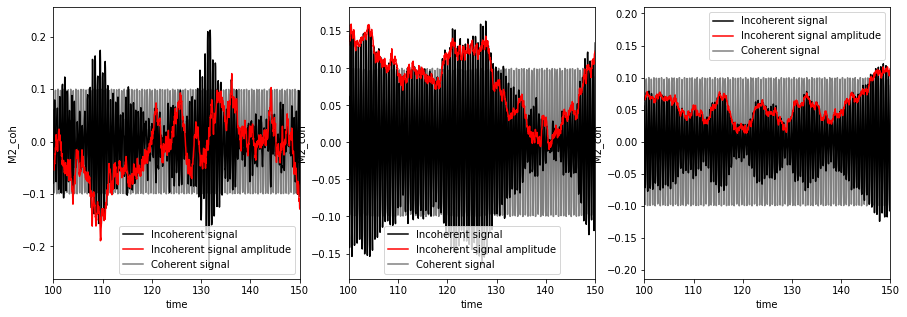

In [18]:
fig,axs = plt.subplots(1,3,figsize=(15,5))

ds.M2_inc.real.sel(draw=0,T=5).plot(ax=axs[0],xlim=(100,150),c='k',label='Incoherent signal')
ds.M2_inc_demodulated.real.sel(draw=0,T=5
                              ).plot(ax=axs[0],xlim=(100,150),c='r',label='Incoherent signal amplitude')
ds.M2_coh.real.plot(ax=axs[0],xlim=(100,150),zorder=-1,c='grey', label = 'Coherent signal')
axs[0].legend()

ds.M2_inc.real.sel(draw=0,T=30).plot(ax=axs[1],xlim=(100,150),c='k',label='Incoherent signal')
ds.M2_inc_demodulated.real.sel(draw=0,T=30
                              ).plot(ax=axs[1],xlim=(100,150),c='r',label='Incoherent signal amplitude')
ds.M2_coh.real.plot(ax=axs[1],xlim=(100,150),zorder=-1,c='grey', label = 'Coherent signal')
axs[1].legend()

ds.M2_inc.real.sel(draw=0,T=80).plot(ax=axs[2],xlim=(100,150),c='k',label='Incoherent signal')
ds.M2_inc_demodulated.real.sel(draw=0,T=80
                              ).plot(ax=axs[2],xlim=(100,150),c='r',label='Incoherent signal amplitude')
ds.M2_coh.real.plot(ax=axs[2],xlim=(100,150),zorder=-1,c='grey', label = 'Coherent signal')
axs[2].legend()


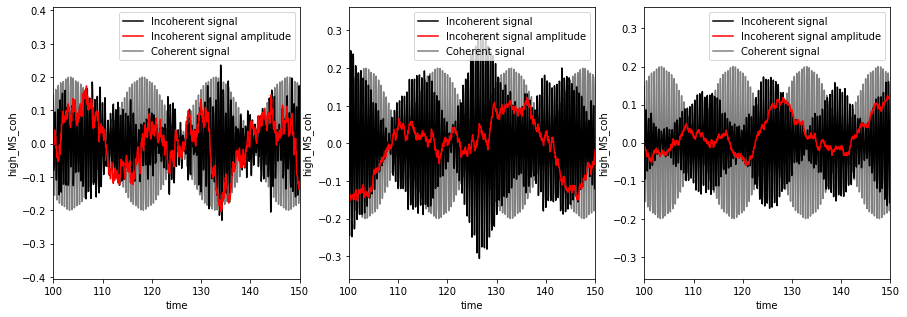

In [19]:
fig,axs = plt.subplots(1,3,figsize=(15,5))

ds.high_MS_inc.real.sel(draw=0,T=5).plot(ax=axs[0],xlim=(100,150),c='k',label='Incoherent signal')
ds.high_MS_inc_demodulated.real.sel(draw=0,T=5
                              ).plot(ax=axs[0],xlim=(100,150),c='r',label='Incoherent signal amplitude')
ds.high_MS_coh.real.plot(ax=axs[0],xlim=(100,150),zorder=-1,c='grey', label = 'Coherent signal')
axs[0].legend()

ds.high_MS_inc.real.sel(draw=0,T=30).plot(ax=axs[1],xlim=(100,150),c='k',label='Incoherent signal')
ds.high_MS_inc_demodulated.real.sel(draw=0,T=30
                              ).plot(ax=axs[1],xlim=(100,150),c='r',label='Incoherent signal amplitude')
ds.high_MS_coh.real.plot(ax=axs[1],xlim=(100,150),zorder=-1,c='grey', label = 'Coherent signal')
axs[1].legend()

ds.high_MS_inc.real.sel(draw=0,T=80).plot(ax=axs[2],xlim=(100,150),c='k',label='Incoherent signal')
ds.high_MS_inc_demodulated.real.sel(draw=0,T=80
                              ).plot(ax=axs[2],xlim=(100,150),c='r',label='Incoherent signal amplitude')
ds.high_MS_coh.real.plot(ax=axs[2],xlim=(100,150),zorder=-1,c='grey', label = 'Coherent signal')
axs[2].legend()

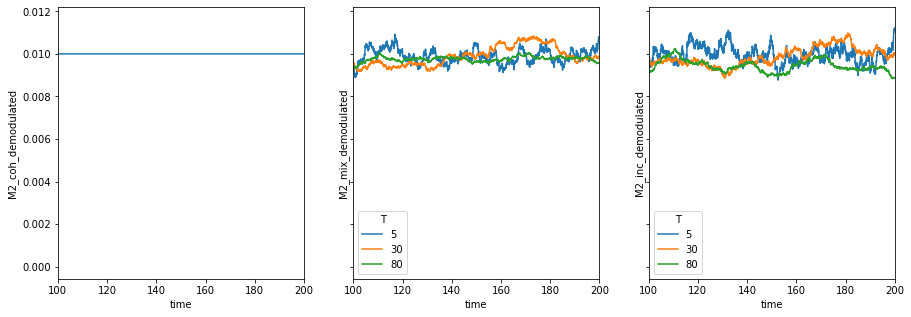

In [20]:
delta_T = 200
fig,axs = plt.subplots(1,3,figsize=(15,5),sharey=True)
c = 'M2_coh'
#ds[c+'_demodulated'].real.plot(ax=axs[0],xlim=(0,delta_T))
#ds[c+'_demodulated'].imag.plot(ax=axs[0],xlim=(0,delta_T))
(np.abs(ds[c+'_demodulated'])**2).plot(ax=axs[0],xlim=(100,delta_T))
    
for ax,c in zip(axs[1:],['M2_mix','M2_inc']):
#    ds[c+'_demodulated'].mean('draw').real.plot(ax=ax,xlim=(0,delta_T),hue='T')
#    ds[c+'_demodulated'].imag.mean('draw').sel(T=80).plot(ax=ax,xlim=(0,delta_T))
    (np.abs(ds[c+'_demodulated'])**2).mean('draw').plot(ax=ax,xlim=(100,delta_T),hue='T') #,hue='T'

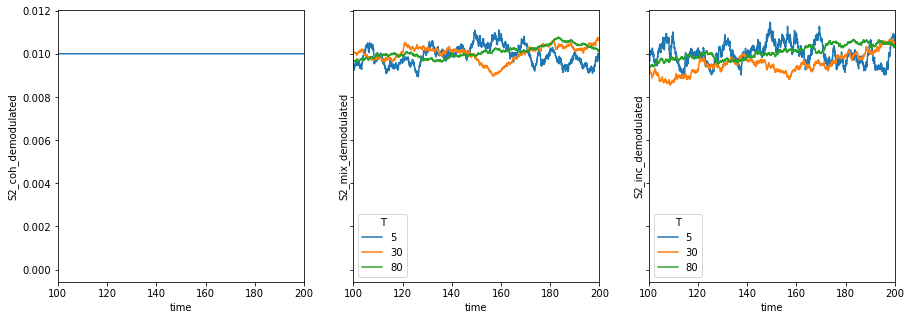

In [21]:
delta_T = 200
fig,axs = plt.subplots(1,3,figsize=(15,5),sharey=True)
c = 'S2_coh'
(np.abs(ds[c+'_demodulated'])**2).plot(ax=axs[0],xlim=(100,delta_T))
    
for ax,c in zip(axs[1:],['S2_mix','S2_inc']):
    (np.abs(ds[c+'_demodulated'])**2).mean('draw').plot(ax=ax,xlim=(100,delta_T),hue='T') #,hue='T'

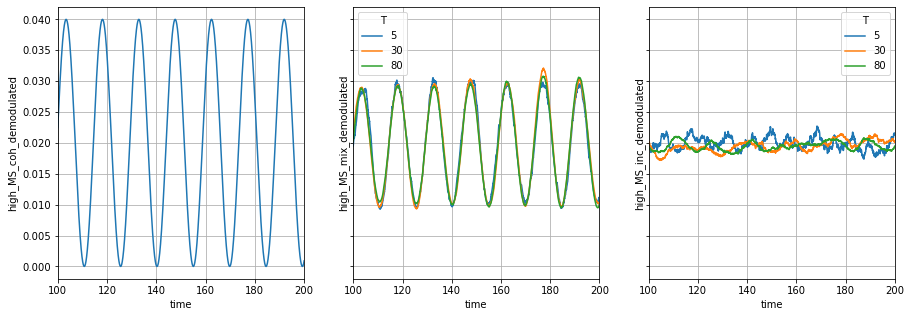

In [22]:
delta_T = 200
fig,axes = plt.subplots(1,3,figsize=(15,5),sharey=True)
axs = axes[:]
c = 'high_MS_coh'
#ds[c+'_demodulated'].real.plot(ax=axs[0],xlim=(0,delta_T))
#ds[c+'_demodulated'].imag.plot(ax=axs[0],xlim=(0,delta_T))
(np.abs(ds[c+'_demodulated'])**2).plot(ax=axs[0],xlim=(100,delta_T))
axs[0].grid()
for ax,c in zip(axs[1:],['high_MS_mix','high_MS_inc']):

    (np.abs(ds[c+'_demodulated'])**2).mean('draw').sel(T=[5,30,80]).plot(ax=ax,xlim=(100,delta_T),hue='T')
    ax.grid()
#axs = axes[1,:]
#for ax,c in zip(axs[1:],['high_MS_mix','high_MS_inc']):
#    ds[c+'_demodulated'].real.mean('draw').sel(T=30).plot(ax=ax,xlim=(0,delta_T))
#    ds[c+'_demodulated'].imag.mean('draw').sel(T=30).plot(ax=ax,xlim=(0,delta_T))
#    (np.abs(ds[c+'_demodulated'])**2).mean('draw').sel(T=30).plot(ax=ax,xlim=(0,delta_T))
    
#axs = axes[2,:]
#for ax,c in zip(axs[1:],['high_MS_mix','high_MS_inc']):
#    ds[c+'_demodulated'].real.mean('draw').sel(T=15).plot(ax=ax,xlim=(0,delta_T))
#    ds[c+'_demodulated'].imag.mean('draw').sel(T=15).plot(ax=ax,xlim=(0,delta_T))
#   (np.abs(ds[c+'_demodulated'])**2).mean('draw').sel(T=15).plot(ax=ax,xlim=(0,delta_T))

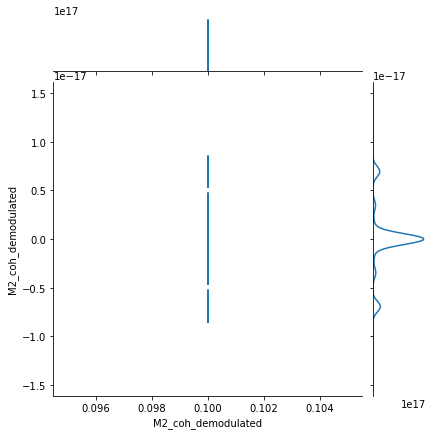

In [23]:
import seaborn as sns
sns.jointplot(x=ds.M2_coh_demodulated.real,y = ds.M2_coh_demodulated.imag,kind='kde')

In [24]:
ds.M2_mix_demodulated.sel(T=5).mean('draw').real

<xarray.DataArray 'M2_mix_demodulated' (time: 7200)>
dask.array<real, shape=(7200,), dtype=float64, chunksize=(7200,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 299.9 299.9 300.0
    T        int64 5

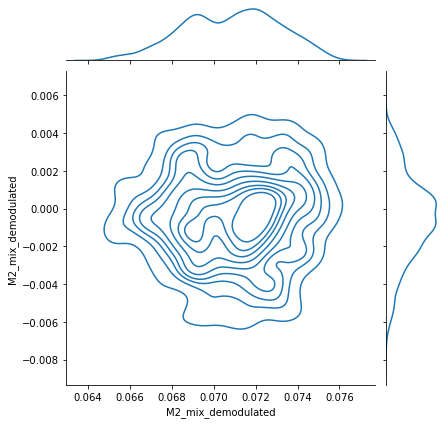

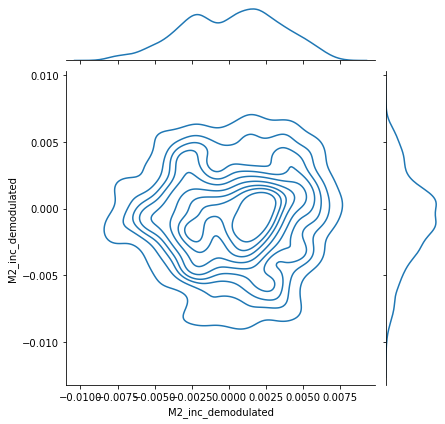

In [27]:
sns.jointplot(x=ds_mean.M2_mix_demodulated.sel(T=5).real,
              y = ds_mean.M2_mix_demodulated.sel(T=5).imag,kind='kde')
sns.jointplot(x=ds_mean.M2_inc_demodulated.sel(T=5).real,
              y = ds_mean.M2_inc_demodulated.sel(T=5).imag,kind='kde')
#sns.jointplot(x=ds.M2_mix_demodulated.sel(T=30).mean('draw').real,
#              y = ds.M2_mix_demodulated.sel(T=30).imag,kind='kde')
#sns.jointplot(x=ds.M2_mix_demodulated.sel(T=80).mean('draw').real,
#              y = ds.M2_mix_demodulated.sel(T=80).imag,kind='kde')

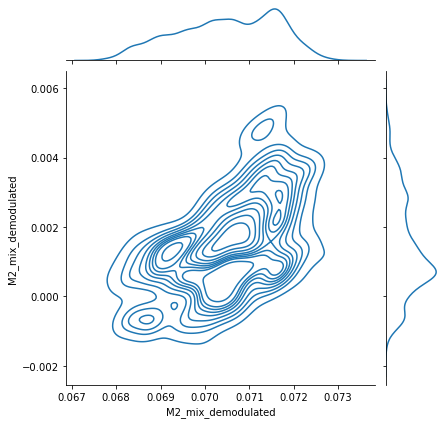

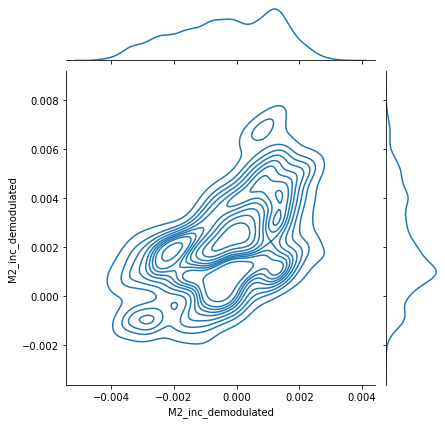

In [26]:
sns.jointplot(x=ds_mean.M2_mix_demodulated.sel(T=80).real,
              y = ds_mean.M2_mix_demodulated.sel(T=80).imag,kind='kde')

sns.jointplot(x=ds_mean.M2_inc_demodulated.sel(T=80).real,
              y = ds_mean.M2_inc_demodulated.sel(T=80).imag,kind='kde')

In [29]:
u_low = hf.low_frequency_signal()
p = dict(U=1.)

low = u_low.generate_tseries(params=p, seed=10,T=T_low,time=(t_size,1/24),draws=nb_draws
                            ).rename('low_signal').persist()
low = low.rename({'T':'T_low'})

In [32]:
ds

<xarray.Dataset>
Dimensions:                  (T: 3, T_low: 3, draw: 500, time: 7200)
Coordinates:
  * time                     (time) float64 0.0 0.04167 0.08333 ... 299.9 300.0
  * T                        (T) int64 5 30 80
  * draw                     (draw) int64 0 1 2 3 4 5 ... 495 496 497 498 499
  * T_low                    (T_low) int64 5 15 30
Data variables:
    M2_coh                   (time) complex128 (0.1+0j) ... (-0.08031686801596918-0.05957516858646216j)
    S2_coh                   (time) complex128 (0.1+0j) ... (0.08660254037841576-0.05000000000004867j)
    high_MS_coh              (time) complex128 (0.2+0j) ... (0.006285672362446579-0.10957516858651084j)
    M2_mix                   (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    S2_mix                   (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    high_MS_mix              (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    M2_inc                   (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    S2_inc                   (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    high_MS_inc              (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    M2_coh_demodulated       (time) complex128 (0.1+0j) ... (0.1+0j)
    M2_mix_demodulated       (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    M2_inc_demodulated       (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    S2_coh_demodulated       (time) complex128 (0.1+0j) ... (0.1+6.938893903907228e-18j)
    S2_mix_demodulated       (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    S2_inc_demodulated       (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    high_MS_coh_demodulated  (time) complex128 (0.2+0j) ... (0.10975530623988207+2.4951395116712405e-14j)
    high_MS_mix_demodulated  (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    high_MS_inc_demodulated  (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    low                      (T_low, time, draw) float64 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>

In [31]:
ds['low'] = low
ds = ds.persist()

In [33]:
ds['total_coh'] = ds['high_MS_coh']+ds['low']
ds['total_mix'] = ds['high_MS_mix']+ds['low']
ds['total_inc'] = ds['high_MS_inc']+ds['low']
ds = ds.persist()

In [34]:
ds_mean = ds.mean('draw').persist()

In [35]:
ds_filtered = {}
for c,om in zip(['M2','S2','high_MS','total'],[omega_M2,omega_S2,omega,omega]):
    for p in ['_coh','_mix','_inc']:
        ds_filtered[c+p] = xr.concat([sigp.bpass_demodulate(ds[c+p].real, om, dband, 30)[0] for dband in [0.1,0.2,0.3]],dim='bandwidth'
                              ).assign_coords({'bandwidth':[0.2,0.4,0.6]})

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:59703
Traceback (most recent call last):
  File "/opt/anaconda3/envs/croco/lib/python3.7/site-packages/distributed/comm/tcp.py", line 187, in read
    n_frames = await stream.read_bytes(8)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/opt/anaconda3/envs/croco/lib/python3.7/site-packages/distributed/worker.py", line 1980, in gather_dep
    self.rpc, deps, worker, who=self.address
  File "/opt/anaconda3/envs/croco/lib/python3.7/site-packages/distributed/worker.py", line 3255, in get_data_from_worker
    return await retry_operation(_get_data, operation="get_data_from_worker")
  File "/opt/anaconda3/envs/croco/lib/python3.7/site-packages/distributed/utils_comm.py", line 390, in retry_operation
    operation=op

  File "/opt/anaconda3/envs/croco/lib/python3.7/site-packages/distributdistributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

In [77]:
test = xr.concat([sigp.bpass_demodulate(ds['M2_coh'].real, omega_M2, dband, 30)[0] for dband in [0.1,0.2,0.3]],dim='bandwidth'
                              ).assign_coords({'bandwidth':[0.2,0.4,0.6]})

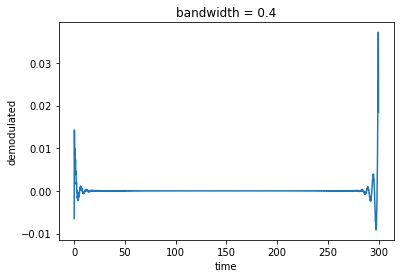

In [82]:
test.demodulated.sel(bandwidth=0.4).imag.plot()

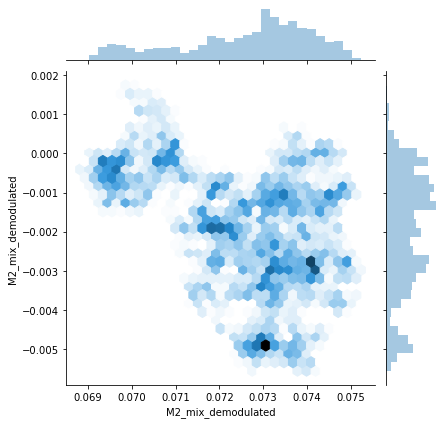

In [91]:
sns.jointplot(x = ds['M2_mix_demodulated'].real.mean('draw').sel(T=80),
              y=ds['M2_mix_demodulated'].imag.mean('draw').sel(T=80),kind="hex")

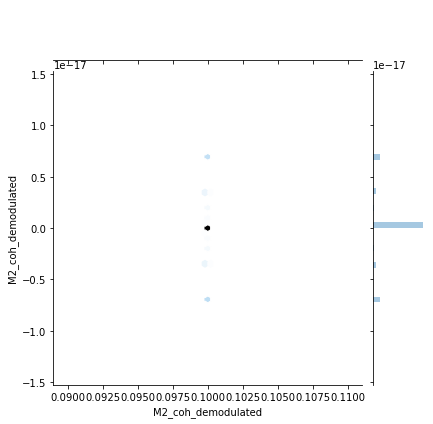

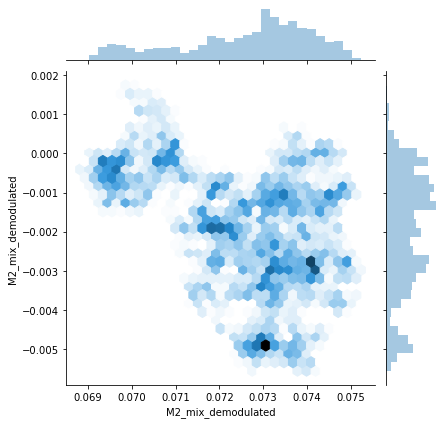

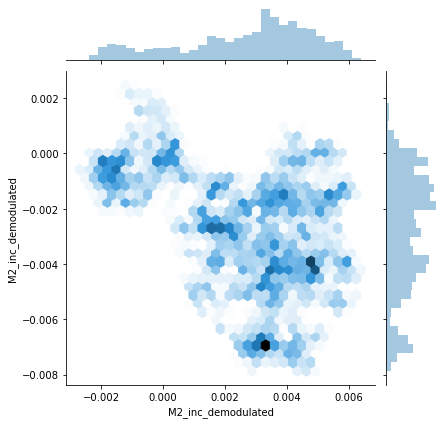

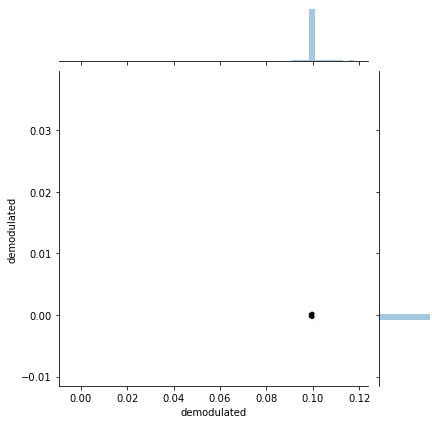

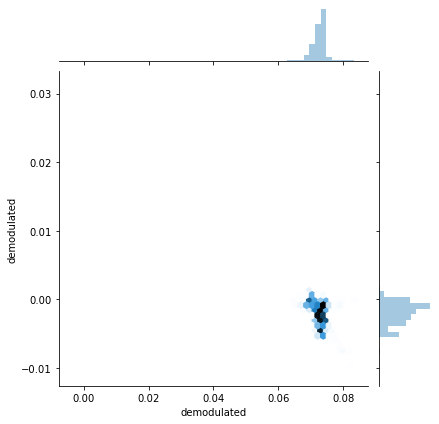

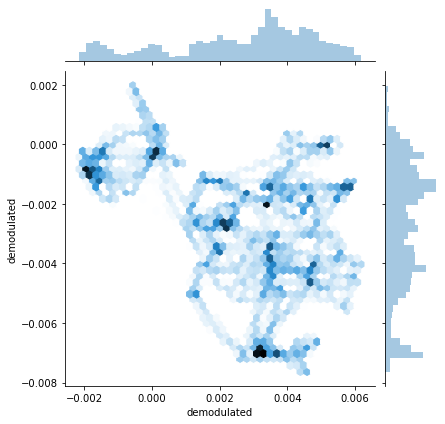

In [85]:
import seaborn as sns
sns.jointplot(x = ds['M2_coh_demodulated'].real,
              y=ds['M2_coh_demodulated'].imag,kind="hex")

sns.jointplot(x = ds['M2_mix_demodulated'].real.mean('draw').sel(T=80),
              y=ds['M2_mix_demodulated'].imag.mean('draw').sel(T=80),kind="hex")

sns.jointplot(x = ds['M2_inc_demodulated'].real.mean('draw').sel(T=80),
              y=ds['M2_inc_demodulated'].imag.mean('draw').sel(T=80),kind="hex")

sns.jointplot(x = ds_filtered['M2_coh'].demodulated.real.sel(bandwidth=0.4),
              y=ds_filtered['M2_coh'].demodulated.imag.sel(bandwidth=0.4),kind="hex")

sns.jointplot(x = ds_filtered['M2_mix'].demodulated.real.mean('draw').sel(T=80),
              y=ds_filtered['M2_mix'].demodulated.imag.mean('draw').sel(T=80),kind="hex")

sns.jointplot(x = ds_filtered['M2_inc'].demodulated.real.mean('draw').sel(T=80),
              y=ds_filtered['M2_inc'].demodulated.imag.mean('draw').sel(T=80),kind="hex")

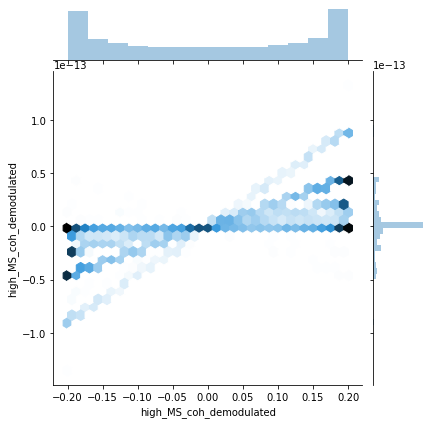

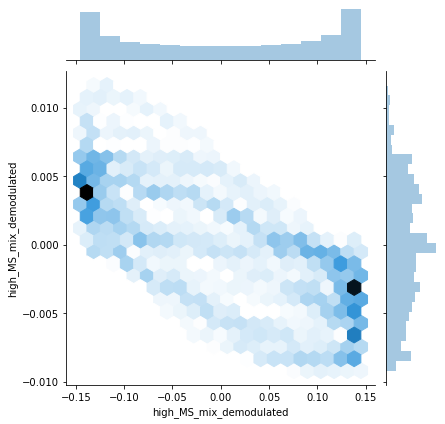

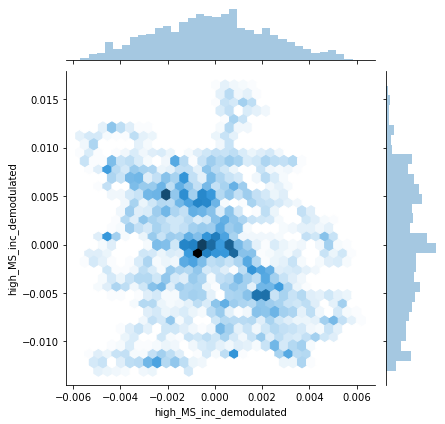

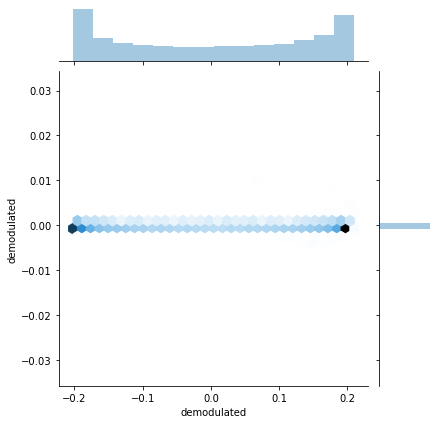

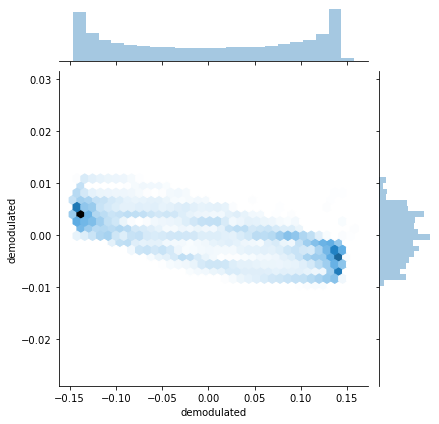

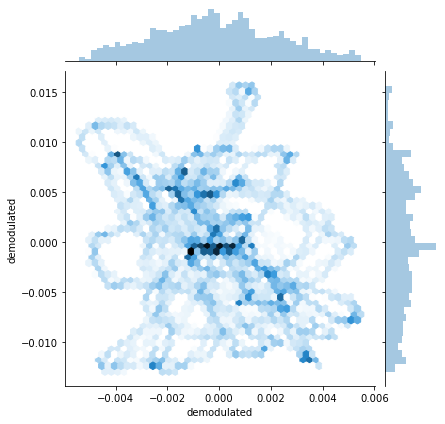

In [34]:
import seaborn as sns
sns.jointplot(x = ds['high_MS_coh_demodulated'].real,
              y=ds['high_MS_coh_demodulated'].imag,kind="hex")

sns.jointplot(x = ds['high_MS_mix_demodulated'].real.mean('draw').sel(T=80),
              y=ds['high_MS_mix_demodulated'].imag.mean('draw').sel(T=80),kind="hex")

sns.jointplot(x = ds['high_MS_inc_demodulated'].real.mean('draw').sel(T=80),
              y=ds['high_MS_inc_demodulated'].imag.mean('draw').sel(T=80),kind="hex")

sns.jointplot(x = ds_filtered['high_MS_coh'].demodulated.real.sel(bandwidth=0.4),
              y=ds_filtered['high_MS_coh'].demodulated.imag.sel(bandwidth=0.4),kind="hex")

sns.jointplot(x = ds_filtered['high_MS_mix'].demodulated.real.mean('draw').sel(T=80),
              y=ds_filtered['high_MS_mix'].demodulated.imag.mean('draw').sel(T=80),kind="hex")

sns.jointplot(x = ds_filtered['high_MS_inc'].demodulated.real.mean('draw').sel(T=80),
              y=ds_filtered['high_MS_inc'].demodulated.imag.mean('draw').sel(T=80),kind="hex")

In [54]:
h_M2 = signal.hilbert(ds['M2_coh'].real)

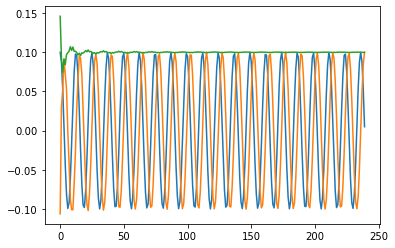

In [65]:
plt.plot(h_M2.real[0:int(10/dt)])
plt.plot(h_M2.imag[0:int(10/dt)])
plt.plot(np.abs(h_M2[0:int(10/dt)]))

In [74]:
h_M2_demod = h_M2*np.exp(-1j*rad*omega_M2*ds.time)

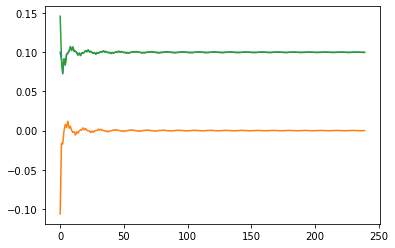

In [75]:
plt.plot(h_M2_demod.real[0:int(10/dt)])
plt.plot(h_M2_demod.imag[0:int(10/dt)])
plt.plot(np.abs(h_M2_demod[0:int(10/dt)]))

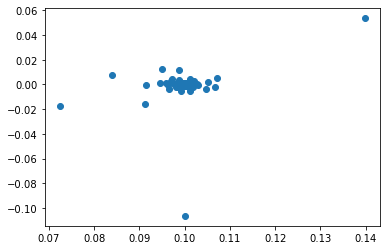

In [76]:
plt.scatter(np.real(h_M2_demod),np.imag(h_M2_demod))

AttributeError: 'JointGrid' object has no attribute 'figure'

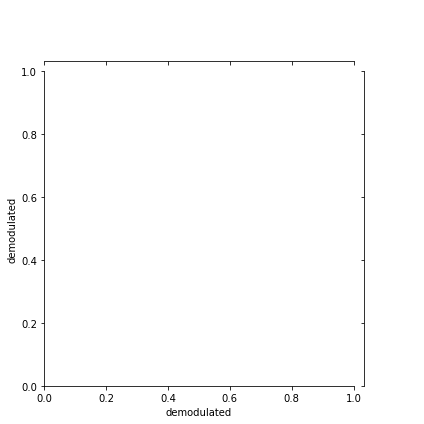

In [32]:


g = sns.JointGrid(x=ds_filtered['M2_coh'].demodulated.real.sel(bandwidth=0.4),
                  y=ds_filtered['M2_coh'].demodulated.real.sel(bandwidth=0.4))

# Create an inset legend for the histogram colorbar
cax = g.figure.add_axes([.15, .55, .02, .2])

# Add the joint and marginal histogram plots
g.plot_joint(
    sns.histplot, discrete=(True, False),
    cmap="light:#03012d", pmax=.8, cbar=True, cbar_ax=cax
)
g.plot_marginals(sns.histplot, element="step", color="#03012d")

(array([4.0000e+00, 5.0000e+00, 4.6000e+01, 1.1916e+04, 1.6000e+01,
        4.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00, 6.0000e+00]),
 array([0.88176461, 0.91739051, 0.9530164 , 0.9886423 , 1.02426819,
        1.05989408, 1.09551998, 1.13114587, 1.16677177, 1.20239766,
        1.23802356]),
 <BarContainer object of 10 artists>)

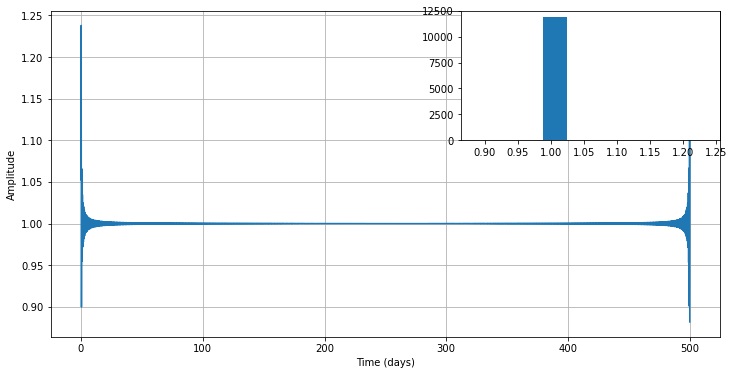

In [30]:
s = np.abs((ds.M2_coh_demodulated)**2).mean('draw')
fig = plt.figure(figsize=(12,6))
plt.plot(ds.time,s)
plt.ylabel('Amplitude');plt.xlabel('Time (days)')
plt.grid()
a = plt.axes([.6, .58, .3, .3])
plt.hist(s)

s = np.abs((ds.high_MS_coh_demodulated)**2).mean('draw')
fig = plt.figure(figsize=(12,6))
plt.plot(ds.time,s)
plt.ylabel('Amplitude');plt.xlabel('Time (days)')
plt.grid()
a = plt.axes([.6, .58, .3, .3])
plt.hist(s)

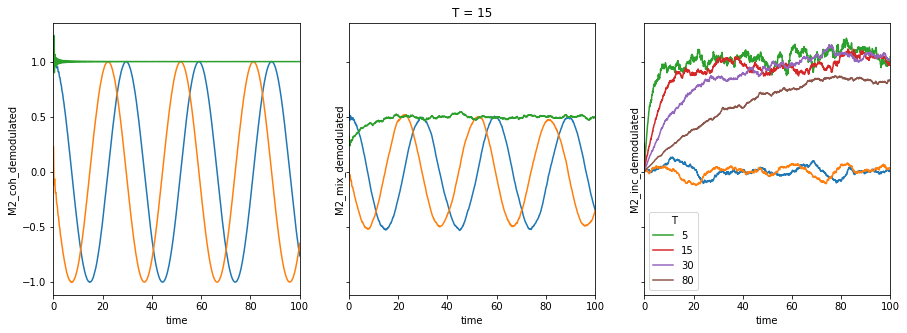

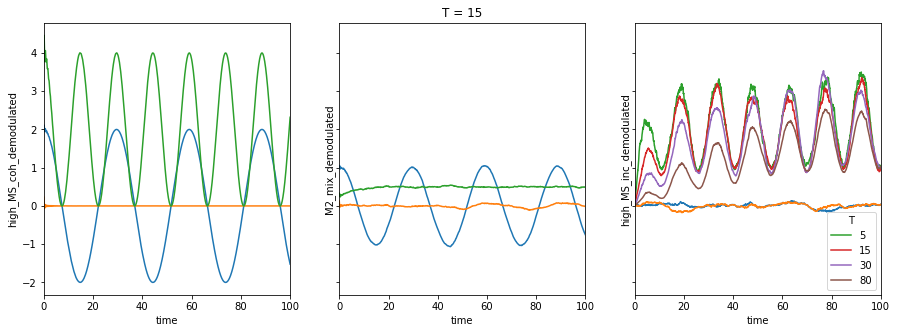

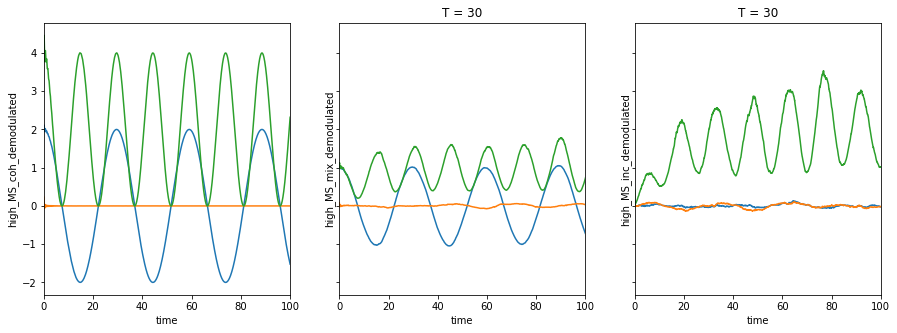

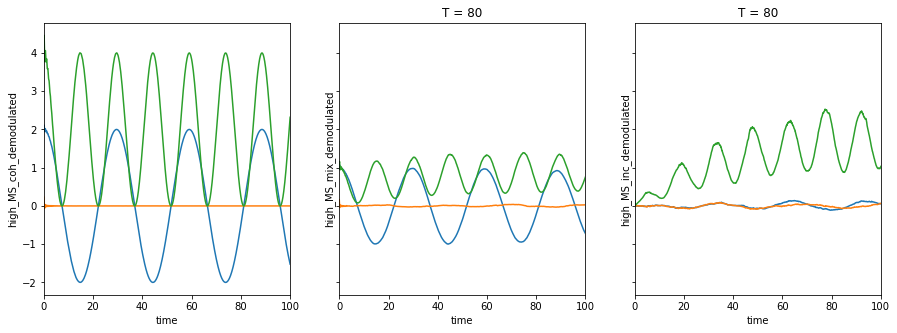

In [38]:
delta_T = 100
fig,axs = plt.subplots(1,3,figsize=(15,5),sharey=True)
ds.M2_coh_demodulated.real.mean('draw').plot(ax=axs[0],xlim=(0,delta_T))
ds.M2_coh_demodulated.imag.mean('draw').plot(ax=axs[0],xlim=(0,delta_T))
(np.abs(ds.M2_coh_demodulated)**2).mean('draw').plot(ax=axs[0],xlim=(0,delta_T))

ds.M2_mix_demodulated.real.mean('draw').sel(T=15).plot(ax=axs[1],xlim=(0,delta_T))
ds.M2_mix_demodulated.imag.mean('draw').sel(T=15).plot(ax=axs[1],xlim=(0,delta_T))
(np.abs(ds.M2_mix_demodulated)**2).mean('draw').sel(T=15).plot(ax=axs[1],xlim=(0,delta_T))

ds.M2_inc_demodulated.real.mean('draw').sel(T=15).plot(ax=axs[2],xlim=(0,delta_T))
ds.M2_inc_demodulated.imag.mean('draw').sel(T=15).plot(ax=axs[2],xlim=(0,delta_T))
(np.abs(ds.M2_inc_demodulated)**2).mean('draw').plot(ax=axs[2],xlim=(0,delta_T),hue='T')

fig,axs = plt.subplots(1,3,figsize=(15,5),sharey=True)
ds.high_MS_coh_demodulated.mean('draw').real.plot(ax=axs[0],xlim=(0,delta_T))
ds.high_MS_coh_demodulated.mean('draw').imag.plot(ax=axs[0],xlim=(0,delta_T))
(np.abs(ds.high_MS_coh_demodulated)**2).mean('draw').plot(ax=axs[0],xlim=(0,delta_T))

ds.high_MS_mix_demodulated.mean('draw').real.sel(T=15).plot(ax=axs[1],xlim=(0,delta_T))
ds.high_MS_mix_demodulated.mean('draw').imag.sel(T=15).plot(ax=axs[1],xlim=(0,delta_T))
(np.abs(ds.M2_mix_demodulated)**2).mean('draw').sel(T=15).plot(ax=axs[1],xlim=(0,delta_T))

ds.high_MS_inc_demodulated.mean('draw').real.sel(T=15).plot(ax=axs[2],xlim=(0,delta_T))
ds.high_MS_inc_demodulated.mean('draw').imag.sel(T=15).plot(ax=axs[2],xlim=(0,delta_T))
(np.abs(ds.high_MS_inc_demodulated)**2).mean('draw').plot(ax=axs[2],xlim=(0,delta_T),hue='T')

fig,axs = plt.subplots(1,3,figsize=(15,5),sharey=True)
ds.high_MS_coh_demodulated.mean('draw').real.plot(ax=axs[0],xlim=(0,delta_T))
ds.high_MS_coh_demodulated.mean('draw').imag.plot(ax=axs[0],xlim=(0,delta_T))
(np.abs(ds.high_MS_coh_demodulated)**2).mean('draw').plot(ax=axs[0],xlim=(0,delta_T))

ds.high_MS_mix_demodulated.mean('draw').real.sel(T=30).plot(ax=axs[1],xlim=(0,delta_T))
ds.high_MS_mix_demodulated.mean('draw').imag.sel(T=30).plot(ax=axs[1],xlim=(0,delta_T))
(np.abs(ds.high_MS_mix_demodulated)**2).mean('draw').sel(T=30).plot(ax=axs[1],xlim=(0,delta_T))

ds.high_MS_inc_demodulated.mean('draw').real.sel(T=30).plot(ax=axs[2],xlim=(0,delta_T))
ds.high_MS_inc_demodulated.mean('draw').imag.sel(T=30).plot(ax=axs[2],xlim=(0,delta_T))
(np.abs(ds.high_MS_inc_demodulated)**2).mean('draw').sel(T=30).plot(ax=axs[2],xlim=(0,delta_T))

fig,axs = plt.subplots(1,3,figsize=(15,5),sharey=True)
ds.high_MS_coh_demodulated.mean('draw').real.plot(ax=axs[0],xlim=(0,delta_T))
ds.high_MS_coh_demodulated.mean('draw').imag.plot(ax=axs[0],xlim=(0,delta_T))
(np.abs(ds.high_MS_coh_demodulated)**2).mean('draw').plot(ax=axs[0],xlim=(0,delta_T))

ds.high_MS_mix_demodulated.mean('draw').real.sel(T=80).plot(ax=axs[1],xlim=(0,delta_T))
ds.high_MS_mix_demodulated.mean('draw').imag.sel(T=80).plot(ax=axs[1],xlim=(0,delta_T))
(np.abs(ds.high_MS_mix_demodulated)**2).mean('draw').sel(T=80).plot(ax=axs[1],xlim=(0,delta_T))

ds.high_MS_inc_demodulated.mean('draw').real.sel(T=80).plot(ax=axs[2],xlim=(0,delta_T))
ds.high_MS_inc_demodulated.mean('draw').imag.sel(T=80).plot(ax=axs[2],xlim=(0,delta_T))
(np.abs(ds.high_MS_inc_demodulated)**2).mean('draw').sel(T=80).plot(ax=axs[2],xlim=(0,delta_T))

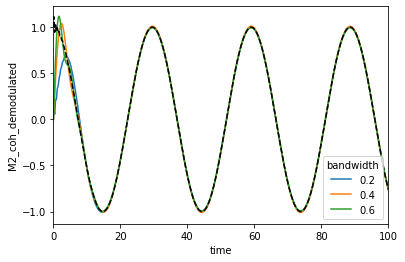

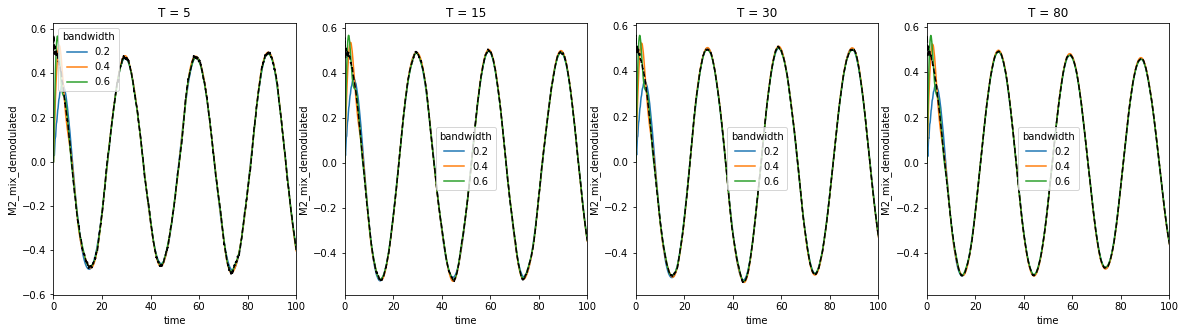

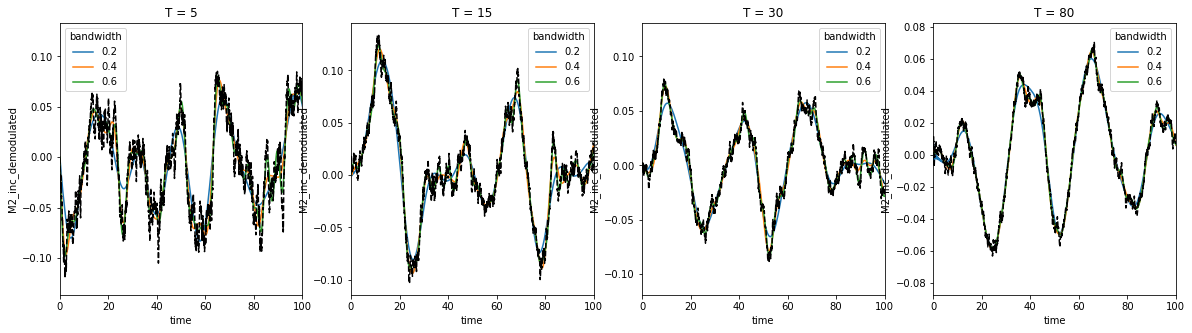

In [39]:
ds_filtered['M2_coh'].demodulated.mean('draw').real.plot(xlim=(0,delta_T),hue='bandwidth')
ds.M2_coh_demodulated.mean('draw').real.plot(c='k',linestyle='--',xlim=(0,delta_T))
fig,axs = plt.subplots(1,ds.T.size,figsize=(5*ds.T.size,5))
for ax ,t in zip(axs,ds.T):
    ds_filtered['M2_mix'].demodulated.mean('draw').real.sel(T=t).plot(ax=ax,xlim=(0,delta_T),hue='bandwidth')
    ds.M2_mix_demodulated.mean('draw').real.sel(T=t).plot(ax=ax,c='k',linestyle='--',xlim=(0,delta_T))

fig,axs = plt.subplots(1,ds.T.size,figsize=(5*ds.T.size,5))
for ax ,t in zip(axs,ds.T):
    ds_filtered['M2_inc'].demodulated.mean('draw').real.sel(T=t).plot(ax=ax,xlim=(0,delta_T),hue='bandwidth')
    ds.M2_inc_demodulated.mean('draw').real.sel(T=t).plot(ax=ax,c='k',linestyle='--',xlim=(0,delta_T))

In [93]:
ds_filtered['M2_coh'].demodulated.real.mean('draw')

<xarray.DataArray 'demodulated' (bandwidth: 3, time: 12000)>
array([[ 7.54683545e-10,  9.43415838e-02,  1.28612472e-01, ...,
         9.88973021e-02,  5.79307074e-02, -1.99162802e-02],
       [ 3.09159729e-09,  6.47760742e-02,  9.87018960e-02, ...,
         8.10057289e-02,  3.69714191e-02, -1.61597619e-02],
       [ 7.08552519e-09,  5.83595948e-02,  1.00107718e-01, ...,
         8.63857223e-02,  3.38337468e-02, -1.44799908e-02]])
Coordinates:
  * time       (time) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0
    exp        (time) complex128 (1+0j) ... (0.9963946710000068+0.08483902169...
  * bandwidth  (bandwidth) float64 0.2 0.4 0.6

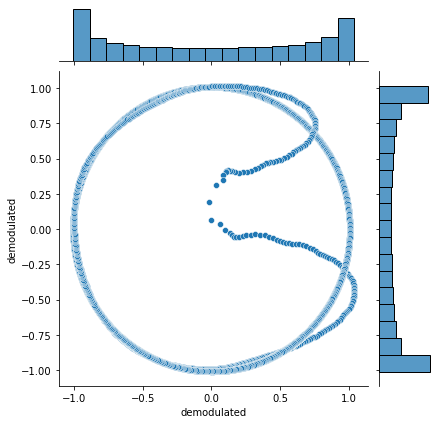

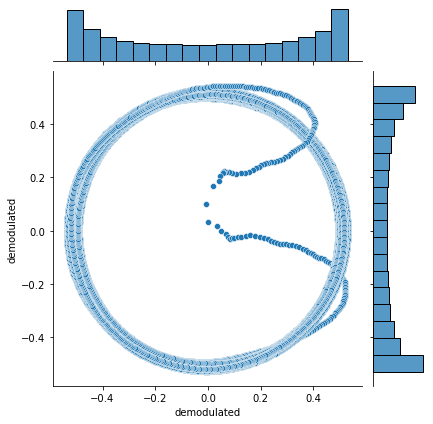

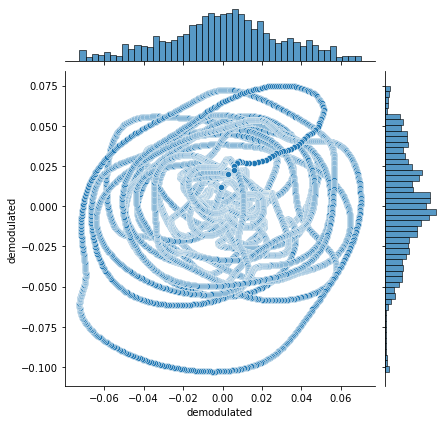

In [97]:
import seaborn as sns
sns.jointplot(x = ds_filtered['M2_coh'].demodulated.real.mean('draw').sel(bandwidth=0.4),y=ds_filtered['M2_coh'].demodulated.imag.mean('draw').sel(bandwidth=0.4),kind="scatter")

sns.jointplot(x = ds_filtered['M2_mix'].demodulated.real.mean('draw').sel(bandwidth=0.4,T=80),y=ds_filtered['M2_mix'].demodulated.imag.mean('draw').sel(bandwidth=0.4,T=80),kind="scatter")

sns.jointplot(x = ds_filtered['M2_inc'].demodulated.real.mean('draw').sel(bandwidth=0.4,T=80),y=ds_filtered['M2_inc'].demodulated.imag.mean('draw').sel(bandwidth=0.4,T=80),kind="scatter")

(array([4.0000e+00, 5.0000e+00, 4.6000e+01, 1.1916e+04, 1.6000e+01,
        4.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00, 6.0000e+00]),
 array([0.88176461, 0.91739051, 0.9530164 , 0.9886423 , 1.02426819,
        1.05989408, 1.09551998, 1.13114587, 1.16677177, 1.20239766,
        1.23802356]),
 <BarContainer object of 10 artists>)

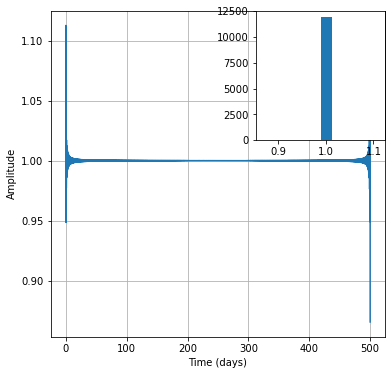

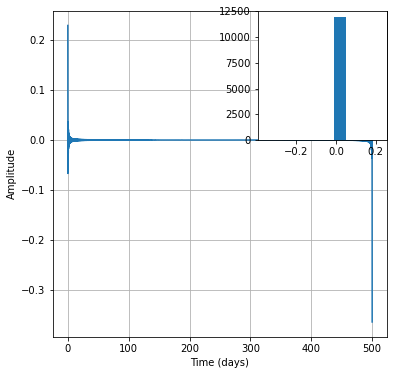

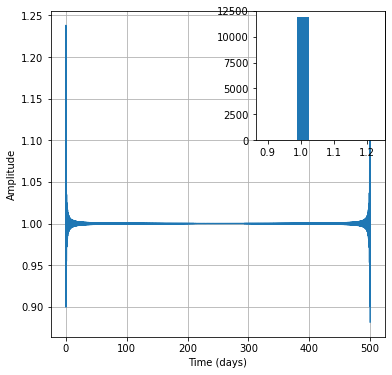

In [95]:
s = ds.M2_coh_demodulated.real.mean('draw')
plt.figure(figsize=(6,6))
plt.plot(ds.time,s)
plt.ylabel('Amplitude');plt.xlabel('Time (days)')
plt.grid()
a = plt.axes([.6, .58, .3, .3])
plt.hist(s)

s = ds.M2_coh_demodulated.imag.mean('draw')
plt.figure(figsize=(6,6))
plt.plot(ds.time,s)
plt.ylabel('Amplitude');plt.xlabel('Time (days)')
plt.grid()
a = plt.axes([.6, .58, .3, .3])
plt.hist(s)

s = np.abs((ds.M2_coh_demodulated)**2).mean('draw')
plt.figure(figsize=(6,6))
plt.plot(ds.time,s)
plt.ylabel('Amplitude');plt.xlabel('Time (days)')
plt.grid()
a = plt.axes([.6, .58, .3, .3])
plt.hist(s)

(array([2611., 1164.,  956.,  879.,  858.,  881.,  961., 1156., 2525.,
           9.]),
 array([5.57766610e-08, 4.46081224e-01, 8.92162392e-01, 1.33824356e+00,
        1.78432473e+00, 2.23040590e+00, 2.67648706e+00, 3.12256823e+00,
        3.56864940e+00, 4.01473057e+00, 4.46081174e+00]),
 <BarContainer object of 10 artists>)

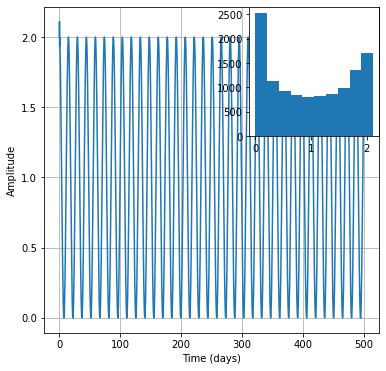

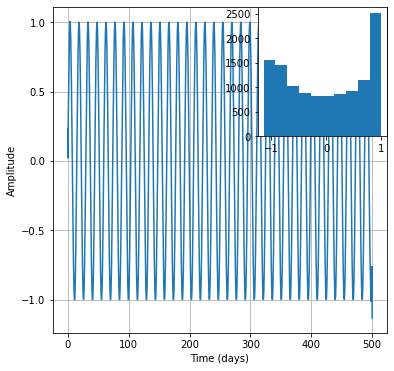

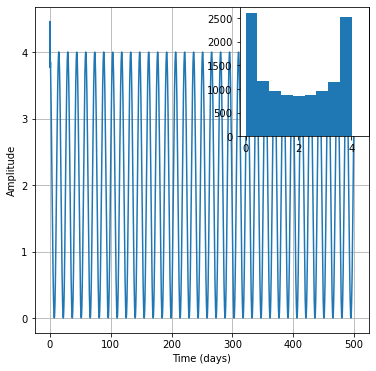

In [96]:
s = ds.high_MS_coh_demodulated.real.mean('draw')
plt.figure(figsize=(6,6))
plt.plot(ds.time,s)
plt.ylabel('Amplitude');plt.xlabel('Time (days)')
plt.grid()
a = plt.axes([.6, .58, .3, .3])
plt.hist(s)

s = ds.high_MS_coh_demodulated.imag.mean('draw')
plt.figure(figsize=(6,6))
plt.plot(ds.time,s)
plt.ylabel('Amplitude');plt.xlabel('Time (days)')
plt.grid()
a = plt.axes([.6, .58, .3, .3])
plt.hist(s)

s = np.abs((ds.high_MS_coh_demodulated)**2).mean('draw')
plt.figure(figsize=(6,6))
plt.plot(ds.time,s)
plt.ylabel('Amplitude');plt.xlabel('Time (days)')
plt.grid()
a = plt.axes([.6, .58, .3, .3])
plt.hist(s)

In [40]:
for k in ds:
    print(k)

M2_coh
S2_coh
high_MS_coh
M2_mix
S2_mix
high_MS_mix
M2_inc
S2_inc
high_MS_inc
M2_coh_complex
M2_coh_demodulated
S2_coh_complex
S2_coh_demodulated
high_MS_coh_complex
high_MS_coh_demodulated


<xarray.DataArray 'M2_mix' (T: 4, time: 12000, draw: 500)>
array([[[ 0.48097769,  0.49743178,  0.40249643, ...,  0.49008918,
          0.55356414,  0.39302964],
        [ 0.34280249,  0.40520294,  0.34517666, ...,  0.44319674,
          0.53377855,  0.29577327],
        [ 0.14709394,  0.23847941,  0.16242037, ...,  0.29303599,
          0.27065344,  0.0948911 ],
        ...,
        [ 0.63114368, -0.74944564,  0.22171349, ...,  0.38427335,
          0.35884655,  0.32131512],
        [ 0.84257254, -0.50109783, -0.14593783, ...,  0.17744272,
          0.60702401,  0.26841609],
        [ 0.81792619, -0.02342099, -0.4377151 , ..., -0.06755619,
          0.56941079,  0.21089767]],

       [[ 0.51738992,  0.45279276,  0.49723836, ...,  0.50999611,
          0.50185642,  0.48859928],
        [ 0.43021637,  0.3595511 ,  0.35275964, ...,  0.45434805,
          0.35660004,  0.41717049],
        [ 0.24962032,  0.21392259,  0.16394051, ...,  0.31144289,
          0.15390115,  0.25646177],
...
        [ 0.27261617,  0.50160283, -0.07244384, ..., -0.17986753,
         -0.36770758,  0.61814493],
        [ 0.20965655,  0.50794996,  0.00499468, ..., -0.02834155,
         -0.43157646,  0.66783176],
        [ 0.09020007,  0.36893995,  0.09134312, ...,  0.12783353,
         -0.39400928,  0.52702565]],

       [[ 0.50027282,  0.51448244,  0.47046603, ...,  0.48778655,
          0.49805674,  0.49189422],
        [ 0.43186806,  0.46385175,  0.44369861, ...,  0.41710469,
          0.44486732,  0.45306352],
        [ 0.266145  ,  0.27968728,  0.28061556, ...,  0.24071803,
          0.28246965,  0.2853744 ],
        ...,
        [ 0.02905515,  0.68900413,  0.36102291, ...,  0.28916456,
         -0.05001233,  0.66650003],
        [-0.06037316,  0.84322145,  0.46640305, ...,  0.48896912,
         -0.05214855,  0.70808011],
        [-0.12901999,  0.75588039,  0.47180875, ...,  0.56270226,
         -0.02608224,  0.56108967]]])
Coordinates:
  * time         (time) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * T            (T) int64 5 15 30 80
    bpassed      (T, draw, time) complex128 (1.5822584676546587e-09-0.0121059...
    demodulated  (T, draw, time) complex128 (1.5822584676546587e-09-0.0121059...
    exp          (time) complex128 (1+0j) ... (0.938091840770205-0.3463866312...
Attributes:
    U:        0.5
    sigma:    12.140833182614747

NameError: name 's' is not defined

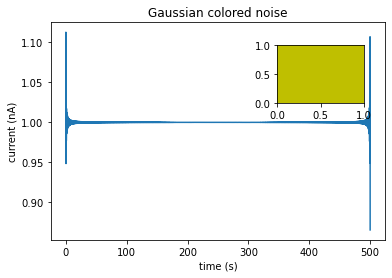

In [76]:
kind  = ['M2','S2','high_MS','total']
_ds_stat = {}
for om,k in zip([omega_M2,omega_S2,omega,omega],kind):
    _ds_stat[k] = xr.combine_nested([[sigp.bpass_demodulate(ds[[k]], om, band, tw)[0] for tw in Tw] for band in dband],concat_dim=['bandwidth','Tw']
                                 ).assign_coords({'Tw':Tw,'bandwidth':[d*2 for d in dband]})#.compute()

In [51]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
rect = [0.2,0.2,0.7,0.7]
inax_position  = ax.transAxes.transform(rect[0:2])
transFigure = fig.transFigure.inverted()
infig_position = transFigure.transform(inax_position)    
x = infig_position[0]
y = infig_position[1]


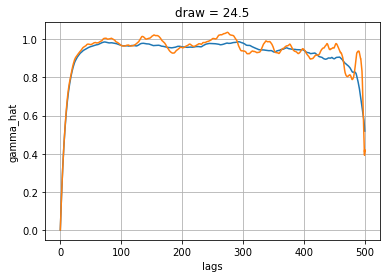

In [54]:
dsw.gamma_hat.mean('draw').plot()
dsw.gamma_hat.isel(draw=0).plot()
plt.grid()

In [20]:
u_total = u_total.rename('total')
u_high = u_high.rename('high')

In [ ]:
ds_high = sigp_AP.svariance(u_high,"time").rename("gammma_hat").to_dataset()
dsw_high = ds_high.coarsen(int(t_size/10)).mean()


In [27]:
ds_total = sigp_AP.svariance(u_total, "time").rename("gamma_hat").to_dataset()

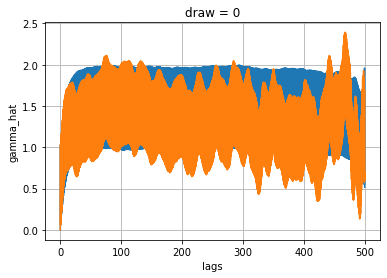

In [28]:
ds_total.gamma_hat.mean('draw').plot()
ds_total.gamma_hat.sel(draw=0).plot()
plt.grid()

In [30]:
dsw_total = ds_total.coarsen(draw = int(t_size/10)).mean()

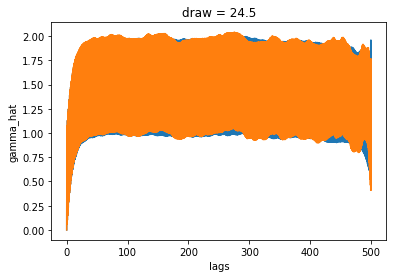

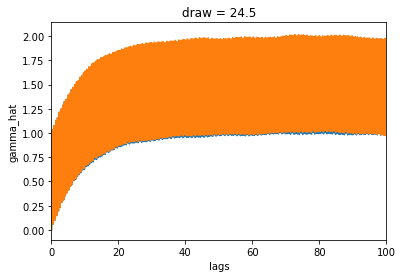

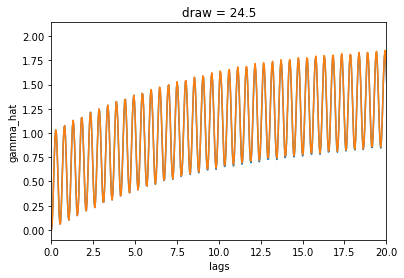

In [33]:
dsw_total.gamma_hat.mean('draw').plot()
dsw_total.gamma_hat.isel(draw=0).plot()

plt.figure()
dsw_total.gamma_hat.mean('draw').plot(xlim=(0,100))
dsw_total.gamma_hat.isel(draw=0).plot(xlim=(0,100))
plt.figure()
dsw_total.gamma_hat.mean('draw').plot(xlim=(0,20))
dsw_total.gamma_hat.isel(draw=0).plot(xlim=(0,20))

In [22]:
u_high_filtered = sigp_AP.bpass_demodulate(u_high,omega,0.2,30)
u_total_filtered = sigp_AP.bpass_demodulate(u_total,omega,0.2,30)

In [27]:
ds_demodulated = sigp_AP.svariance(u_total_filtered[0].demodulated.real, "time").rename("gamma_hat").to_dataset()

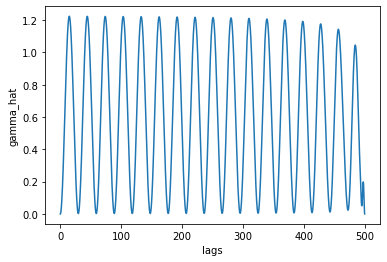

In [29]:
ds_demodulated.gamma_hat.mean('draw').plot()

In [43]:
rad = 2*np.pi
p = dict(U=0.5, Us=.5, T=10., sigma=omega_M2*rad)

u_M2 = u.generate_tseries(params=p, 
                         seed=0,
                         time=(t_size,1/24),
                         draws=nb_draws,name='M2'
                        ).compute()


p = dict(U=0.5, Us=.5, T=10., sigma=omega_S2*rad)

u_S2 = u.generate_tseries(params=p, 
                         seed=0,
                         time=(t_size,1/24),
                         draws=nb_draws,name='S2'
                        ).compute()

u_low = hf.low_frequency_signal()
low = tseries("low",draws=nb_draws,name='low').compute()

In [44]:
u_high = u_M2+u_S2
u_total = u_M2+u_S2+low

In [45]:
u_high = u_high.rename('high')
u_total = u_total.rename('total')

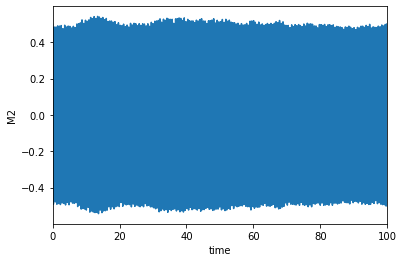

In [56]:
u_M2.mean('draw').plot(xlim=(0,100))

In [34]:
ds_high = sigp_AP.svariance(u_high,"time").rename("gammma_hat").to_dataset()
#dsw_high = ds_high.coarsen(int(t_size/10)).mean()

In [36]:
ds_high

<xarray.Dataset>
Dimensions:     (draw: 500, lags: 12000)
Coordinates:
  * draw        (draw) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
  * lags        (lags) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0
    N           (lags) int64 12000 11999 11998 11997 11996 11995 ... 5 5 4 2 2 1
Data variables:
    gammma_hat  (draw, lags) float64 0.0 0.05064 0.1858 ... 1.087 1.202 1.098

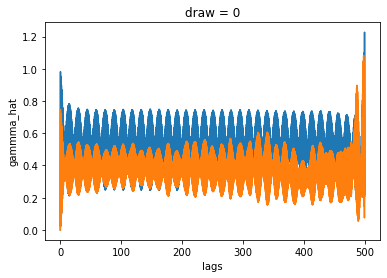

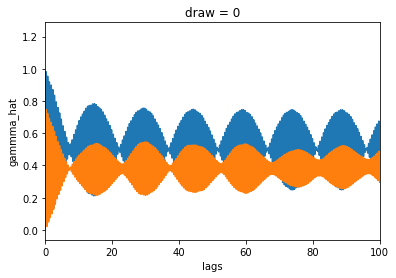

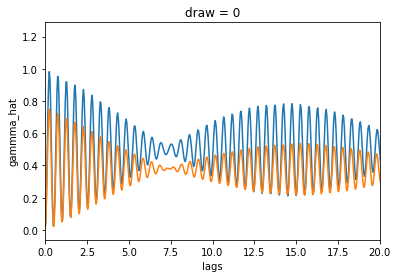

In [37]:
ds_high.gammma_hat.mean('draw').plot()
ds_high.gammma_hat.sel(draw=0).plot()

plt.figure()
ds_high.gammma_hat.mean('draw').plot(xlim=(0,100))
ds_high.gammma_hat.sel(draw=0).plot(xlim=(0,100))

plt.figure()
ds_high.gammma_hat.mean('draw').plot(xlim=(0,20))
ds_high.gammma_hat.sel(draw=0).plot(xlim=(0,20))

In [46]:
u_high_filtered = sigp_AP.bpass_demodulate(u_high,omega,0.2,30)
u_total_filtered = sigp_AP.bpass_demodulate(u_total,omega,0.2,30)

In [47]:
ds_total = sigp_AP.svariance(u_total_filtered[0].demodulated.real,"time").rename("gamma_hat").to_dataset()

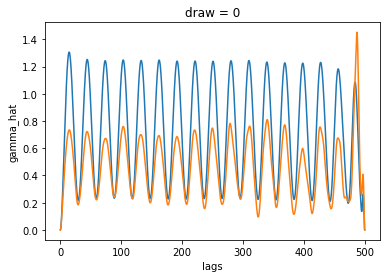

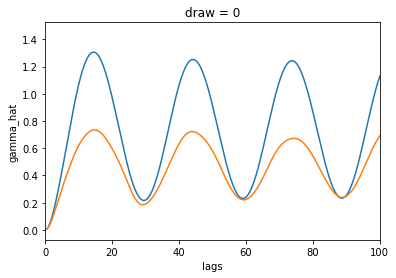

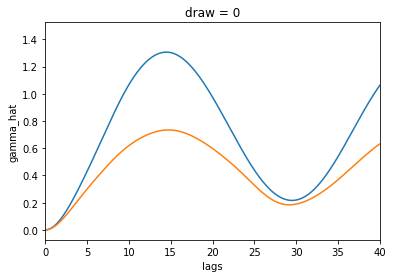

In [48]:
ds_total.gamma_hat.mean('draw').plot()
ds_total.gamma_hat.sel(draw=0).plot()

plt.figure()
ds_total.gamma_hat.mean('draw').plot(xlim=(0,100))
ds_total.gamma_hat.sel(draw=0).plot(xlim=(0,100))

plt.figure()
ds_total.gamma_hat.mean('draw').plot(xlim=(0,40))
ds_total.gamma_hat.sel(draw=0).plot(xlim=(0,40))

In [50]:
dsw_total = ds_total.coarsen(draw=int(t_size/10)).mean()

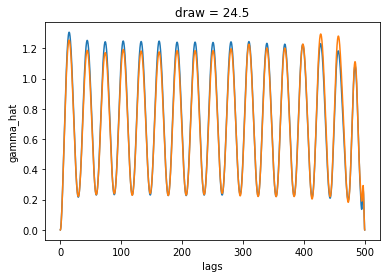

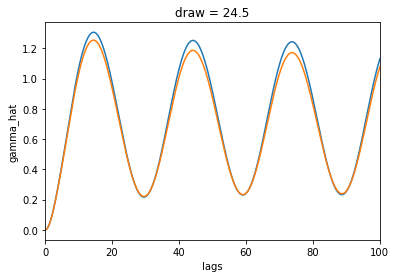

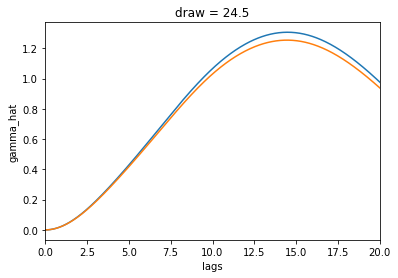

In [52]:
dsw_total.gamma_hat.mean('draw').plot()
dsw_total.gamma_hat.isel(draw=0).plot()

plt.figure()
dsw_total.gamma_hat.mean('draw').plot(xlim=(0,100))
dsw_total.gamma_hat.isel(draw=0).plot(xlim=(0,100))

plt.figure()
dsw_total.gamma_hat.mean('draw').plot(xlim=(0,20))
dsw_total.gamma_hat.isel(draw=0).plot(xlim=(0,20))

In [25]:
kind = ['M2','S2','high','total'] #'high_MSNK',
_ds,h = {},{}
for om,k in zip([omega_M2,omega_S2,omega,omega],kind):
    _ds[k] = xr.combine_nested([[sigp.bpass_demodulate(ds[[k]], om, band, tw)[0] for tw in Tw] for band in dband],concat_dim=['bandwidth','Tw']
                                 ).assign_coords({'Tw':Tw,'bandwidth':[d*2 for d in dband]})
    h[k] = [[sigp.bpass_demodulate(ds[[k]], om, band, tw)[1] for tw in Tw] for band in dband]

In [18]:
ds = xr.merge([u_M2,u_S2,u_high.rename('high'),u_total.rename('total')])
ds

<xarray.Dataset>
Dimensions:  (T: 3, draw: 30, time: 24000)
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 20 21 22 23 24 25 26 27 28 29
  * T        (T) int64 5 30 100
Data variables:
    M2       (time, draw) float64 dask.array<chunksize=(24000, 30), meta=np.ndarray>
    S2       (time, draw) float64 dask.array<chunksize=(24000, 30), meta=np.ndarray>
    high     (time, draw) float64 dask.array<chunksize=(24000, 30), meta=np.ndarray>
    total    (time, draw, T) float64 dask.array<chunksize=(24000, 30, 3), meta=np.ndarray>

In [19]:
kind = ['M2','S2','high','total'] #'high_MSNK',
_ds,h = {},{}
for om,k in zip([omega_M2,omega_S2,omega,omega],kind):
    _ds[k] = xr.combine_nested([[sigp.bpass_demodulate(ds[[k]], om, band, tw)[0] for tw in Tw] for band in dband],concat_dim=['bandwidth','Tw']
                                 ).assign_coords({'Tw':Tw,'bandwidth':[d*2 for d in dband]})
    h[k] = [[sigp.bpass_demodulate(ds[[k]], om, band, tw)[1] for tw in Tw] for band in dband]



In [22]:
R = {}
maxlag=1000
lags= np.arange(0,maxlag//2,1/24)
#kind = ['high_M2','high_S2','high_MS','high_MSNK','total']
for k in kind:
    R[k] = autocorrelations(_ds[k],[k],maxlag=None,lags = lags,**{'mode':'same'})

In [23]:
ds_R = xr.merge([R[k] for k in kind])

In [24]:
ds_R_mean = ds_R.mean('draw').compute()

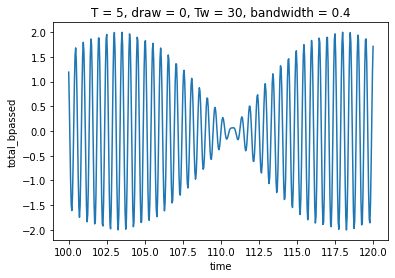

In [25]:
_ds['total'].total_bpassed.real.sel(draw=0,Tw=30,T=5,bandwidth=0.4).sel(time=slice(100,120)).plot()

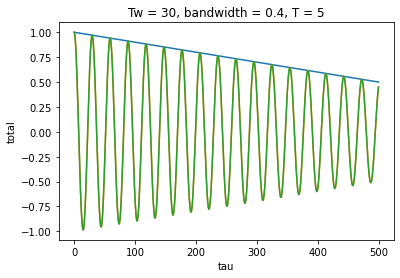

In [26]:
(ds_R_mean.M2/ds_R_mean.M2.isel(tau=0)).sel(bandwidth=0.4,Tw=30).plot()
(ds_R_mean.high/ds_R_mean.high.isel(tau=0)).sel(bandwidth=0.4,Tw=30).plot()
(ds_R_mean.total/ds_R_mean.total.isel(tau=0)).sel(bandwidth=0.4,Tw=30,T=5).plot()

Notes : 
Pas de contamination par la basse fréquence.

In [27]:
R_valid = {}
maxlag=1000
lags= np.arange(0,maxlag//2,1/24)
#kind = ['high_M2','high_S2','high_MS','high_MSNK','total']
for k in kind:
    R_valid[k] = autocorrelations(_ds[k],[k],maxlag=maxlag,lags = lags,**{'mode':'valid'})

In [28]:
ds_R_valid = xr.merge([R_valid[k] for k in kind])

In [29]:
ds_R_mean_valid = ds_R_valid.mean('draw').compute()

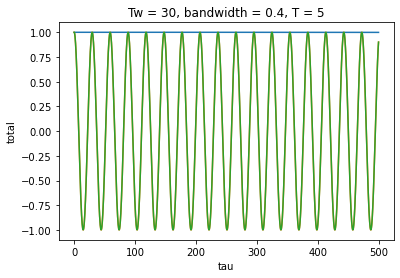

In [30]:
(ds_R_mean_valid.M2/ds_R_mean_valid.M2.isel(tau=0)).sel(bandwidth=0.4,Tw=30).plot()
(ds_R_mean_valid.high/ds_R_mean_valid.high.isel(tau=0)).sel(bandwidth=0.4,Tw=30).plot()
(ds_R_mean_valid.total/ds_R_mean_valid.total.isel(tau=0)).sel(bandwidth=0.4,Tw=30,T=5).plot()

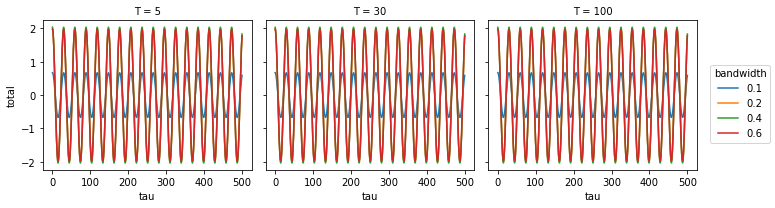

In [35]:
ds_R_mean_valid.total.sel(Tw=30).plot(col='T',hue='bandwidth')

In [31]:
ds_R_mean.to_netcdf('/Users/zcaspar/codes/mit4320/synthetic_30_same.nc')
ds_R_mean_valid.to_netcdf('/Users/zcaspar/codes/mit4320/synthetic_30_valid.nc')

###  Incoherent signal : 1 draw

In [12]:
# actually generate time series

u_low = hf.low_frequency_signal()
u_high = hf.high_frequency_signal()
da_high_M2 = tseries("high_M2",draws=1,name='high_M2').persist()
#da_high_M2 = da_high_M2.rename('high_M2')
da_high_S2 = tseries("high_S2",draws=1,name='high_S2').persist()
#da_high_S2 = da_high_S2.rename('high_S2')
#da_high_N2 = tseries("high_N2",draws=1).persist()
#da_high_N2 = da_high_N2.rename('high_N2')
#da_high_K2 = tseries("high_K2",draws=1).persist()
#da_high_K2 = da_high_K2.rename('high_K2')


da_low = tseries("low",draws=1).persist()

In [13]:
da_high_M2.attrs = {'sigma_M2':da_high_M2.attrs['sigma']}
da_high_S2.attrs = {'sigma_S2':da_high_S2.attrs['sigma']}

#da_high_N2.attrs = {'sigma_N2':da_high_N2.attrs['sigma']}
#da_high_K2.attrs = {'sigma_K2':da_high_K2.attrs['sigma']}

#ds = xr.merge([da_high_M2,da_high_S2,da_high_N2,da_high_K2, da_low.rename({'T':'T_low'})]) #, combine_attrs="no_conflicts"
#ds = xr.merge([da_high_M2,da_high_S2, da_low.rename({'T':'T_low'})])

#ds

In [14]:
da_high_M2 = xr.concat([da_high_M2*U for U in U_high],dim='U_high').assign_coords({'U_high':U_high})
da_high_S2 = xr.concat([da_high_S2*U for U in U_high],dim='U_high').assign_coords({'U_high':U_high})
ds = xr.merge([da_high_M2,da_high_S2, da_low.rename({'T':'T_low'})])
ds

<xarray.Dataset>
Dimensions:  (T: 5, T_low: 3, U_high: 4, time: 24000)
Coordinates:
  * T        (T) int64 5 10 15 30 80
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * U_high   (U_high) float64 0.01 0.05 0.1 1.0
  * T_low    (T_low) int64 5 30 100
Data variables:
    high_M2  (U_high, T, time) float64 dask.array<chunksize=(1, 5, 24000), meta=np.ndarray>
    high_S2  (U_high, T, time) float64 dask.array<chunksize=(1, 5, 24000), meta=np.ndarray>
    low      (T_low, time) float64 dask.array<chunksize=(3, 24000), meta=np.ndarray>

In [15]:
ds['high_MS'] = ds.high_M2+ds.high_S2
#ds['high_MSNK'] = ds.high_M2+ds.high_S2+ds.high_N2+ds.high_K2
ds['total'] = ds.high_M2+ds.high_S2+ds.low

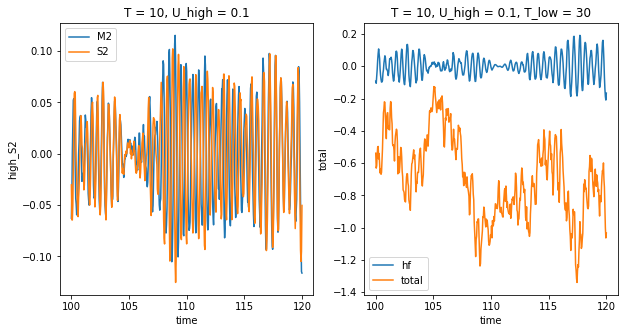

In [16]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ds.high_M2.isel(T=1).sel(U_high=0.1).sel(time=slice(100,120)).plot(ax=ax[0],label='M2')
ds.high_S2.isel(T=1).sel(U_high=0.1).sel(time=slice(100,120)).plot(ax=ax[0],label='S2')
ax[0].legend()
ds.high_MS.isel(T=1).sel(U_high=0.1).sel(time=slice(100,120)).plot(ax=ax[1],label='hf')
ds.total.isel(T_low=1,T=1).sel(U_high=0.1).sel(time=slice(100,120)).plot(ax=ax[1],label='total')
ax[1].legend()

#### Filter and demodulation : 
Band pass filter applied to signal : 
1) monochromatic signal, M2 frequency

2) monochromatic signal, S2 frequency 

3) superpostion of S2 and M2 ; central frequency is the mean frequency

4) total signal (M2+S2+lf) ; central frequency is the mean frequency

Notes on paramters : 

1) halfbandwidth, $d\omega$, should be defined such as : $1/d\omega\geq T_w$; where $T_w$ is the kernel length

2) $d\omega\geq \tilde T$ ; where $\tilde T$ is the hf decorrelation timescale.

In [17]:

kind = ['high_M2','high_S2','high_MS','total'] #'high_MSNK',
_ds,h = {},{}
for om,k in zip([omega_M2,omega_S2,omega,omega],kind):
    _ds[k] = xr.combine_nested([[sigp.bpass_demodulate(ds[[k]], om, band, tw)[0] for tw in Tw] for band in dband],concat_dim=['bandwidth','Tw']
                                 ).assign_coords({'Tw':Tw,'bandwidth':[d*2 for d in dband]})
    h[k] = [[sigp.bpass_demodulate(ds[[k]], om, band, tw)[1] for tw in Tw] for band in dband]


In [18]:
_ds['low'] = ds.low

In [19]:
maxlag=t_size
lags= np.arange(0,maxlag//2,1/24)
R = {}
#kind = ['high_M2','high_S2','high_MS','high_MSNK','total']
for k in kind:
    R[k] = autocorrelations(_ds[k],[k],maxlag = maxlag,lags=lags,**{'mode':'valid'})

In [20]:
ds_R = xr.merge([R[k] for k in kind])

In [21]:
ds_R = ds_R.compute()

In [26]:
R_low = autocorrelations(_ds,['low'],maxlag=maxlag,lags=lags,**{'mode':'valid'})
dsR_low = R_low.compute()

In [27]:
ds_R = xr.merge([ds_R,dsR_low])

In [28]:
#ds_R.to_netcdf('/home1/datawork/zcaspar/mit4320/synthetic_1.nc')
ds_R.to_netcdf('/Users/zcaspar/codes/mit4320/synthetic_1_U.nc')

#### Monochromatic signal ,M2

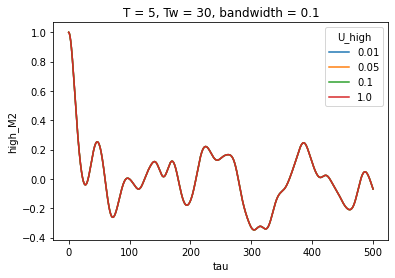

<Figure size 432x288 with 0 Axes>

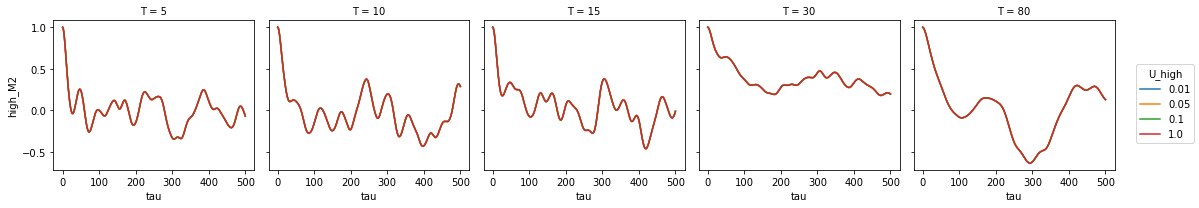

<Figure size 432x288 with 0 Axes>

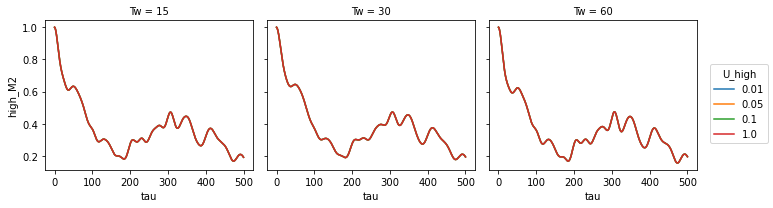

<Figure size 432x288 with 0 Axes>

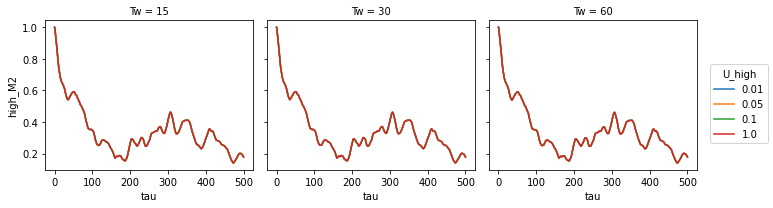

<Figure size 432x288 with 0 Axes>

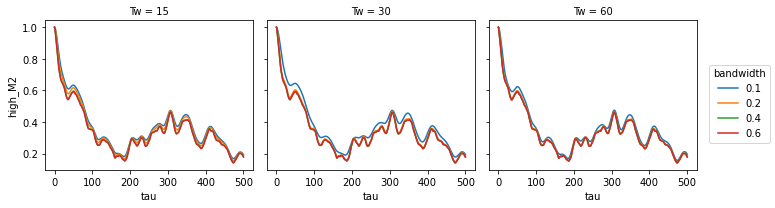

In [30]:
(ds_R.high_M2/ds_R.high_M2.isel(tau=0)).sel(bandwidth=0.1,T=5,Tw=30).plot(hue='U_high')
plt.figure()
(ds_R.high_M2/ds_R.high_M2.isel(tau=0)).sel(bandwidth=0.1,Tw=30).plot(hue='U_high',col='T')

plt.figure()
(ds_R.high_M2/ds_R.high_M2.isel(tau=0)).sel(bandwidth=0.1,T=30).plot(hue='U_high',col='Tw')

plt.figure()
(ds_R.high_M2/ds_R.high_M2.isel(tau=0)).sel(bandwidth=0.6,T=30).plot(hue='U_high',col='Tw')

plt.figure()
(ds_R.high_M2/ds_R.high_M2.isel(tau=0)).sel(T=30,U_high=0.1).plot(hue='bandwidth',col='Tw')

Notes : 

For large enough bandwidth compared to the decorrelation timescale, kernel length and bandwidth do not have impact on the results.

The form of autocovariance changes depending on the amplitude (mean over several samples should correct this).

NB : Short decorrealtion timescale compared to the band width ($\tilde T\leq T_\omega$) introduces oscillations in the autocovariance (expected)

#### High frequency signal (M2+S2)

In [25]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
